# 1 Данные

In [ ]:
! gdown --id 1kEfqmBA-Z5RKmXlnsGEos3Hn45LSmn_j
! unzip archive.zip

In [ ]:
import glob

bad_images = glob.glob('PokemonData/*/*.svg')

In [ ]:
import os
for bad_image in bad_images:
    os.remove(bad_image)

# 2 Реализация Датасета

In [ ]:
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

import os
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [ ]:
class PokemonDataset(Dataset):
    SPLIT_RANDOM_SEED = 42
    TEST_SIZE = 0.25

    def __init__(self, root, train=True, load_to_ram=True, transform=None):
        super().__init__()
        self.root = root
        self.train = train
        self.load_to_ram = load_to_ram
        self.transform = transform
        self.to_tensor = T.ToTensor()
        self.all_files = []
        self.all_labels = []
        self.images = []

        self.classes = sorted(os.listdir(self.root))
        for i, class_name in tqdm(enumerate(self.classes), total=len(self.classes)):
            files = sorted(os.listdir(os.path.join(self.root, class_name)))
            train_files, test_files = train_test_split(files, random_state=self.SPLIT_RANDOM_SEED + i,
                                                       test_size=self.TEST_SIZE)
            if self.train:
                self.all_files += train_files
                self.all_labels += [i] * len(train_files)
                if self.load_to_ram:
                    self.images += self._load_images(train_files, i)

            else:
                self.all_files += test_files
                self.all_labels += [i] * len(test_files)
                if self.load_to_ram:
                    self.images += self._load_images(test_files, i)

    def _load_images(self, image_files, label):
        images = []
        for filename in image_files:
            image = Image.open(os.path.join(self.root, self.classes[label], filename)).convert('RGB')
            images += [image]

        return images

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, item):
        label = self.all_labels[item]
        if self.load_to_ram:
            image = self.images[item]
        else:
            filename = self.all_files[item]
            image = Image.open(os.path.join(self.root, self.classes[label], filename)).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transform = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize,
])

test_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    normalize,
])

In [ ]:
train_dataset = PokemonDataset(root='PokemonData', train=True, load_to_ram=False, transform=test_transform)
test_dataset = PokemonDataset(root='PokemonData', train=False, load_to_ram=False, transform=test_transform)

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# 3 Файн-тьюнинг модели

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [ ]:
# 99e617e25721bb449ecb082f7aacdd444e113b1e
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.2 MB/s eta 0:00:00


In [ ]:
import wandb

def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()

    for i, (images, labels) in enumerate(tqdm(train_loader, desc=tqdm_desc), 1):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        accuracy = (logits.argmax(dim=1) == labels).sum().item()
        train_accuracy += accuracy

        if i % 10 == 0:
            wandb.log({'batch loss': loss.item(), 'batch accuracy': accuracy})

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy


def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs, name):
    wandb.init(project='Pokemon', name=name)
    wandb.watch(model)

    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        wandb.log({
            "epoch": epoch, "train loss": train_loss, "train accuracy": train_accuracy,
            "test loss": test_loss, "test accuracy": test_accuracy,
            "lr": scheduler.get_last_lr()[0] if scheduler is not None else optimizer.param_groups[-1]['lr']
        })

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

    wandb.finish()
    return train_losses, test_losses, train_accuracies, test_accuracies

In [ ]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

# # Transfer learning
# # Доучим последний слой модели. Запретим весам из экстрактора фичей обучаться.
# for param in model.parameters():
#     param.requires_grad = False

# Заменяем исходную голову модели на голову с правильным числом классов
# и с requires_grad=True by default. Иначе будет Finetuning.
model.classifier[1] = torch.nn.Linear(1280, len(train_dataset.classes))
model = model.to(device)

num_epochs = 20
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 67.0MB/s]


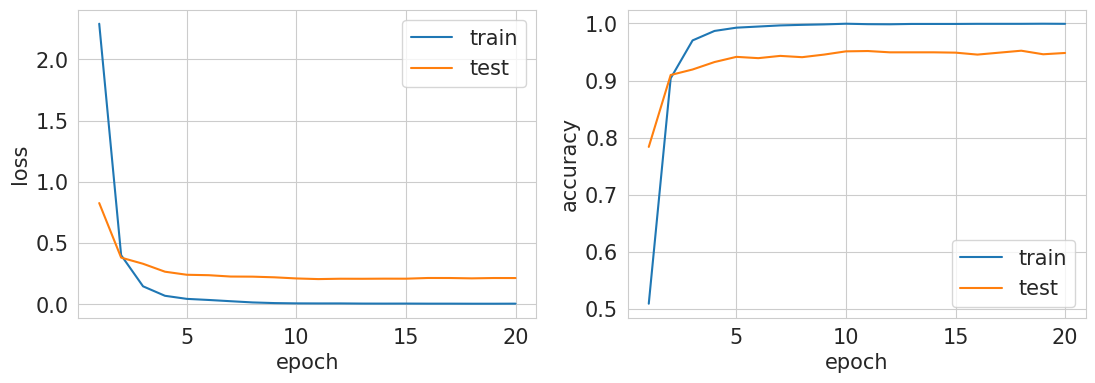

batch accuracy,▁▄▇▇████████████████████████████████████
batch loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
lr,████▇▇▇▆▆▅▄▄▃▃▂▂▂▁▁▁
test accuracy,▁▆▇▇█▇██████████████
test loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train accuracy,▁▇██████████████████
train loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch accuracy,32
batch loss,0.00366
epoch,20


In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader,
    num_epochs, name='MobileNetv2--lr-0.01--aug--fine-tune'
)

# 4 Сохраним модель

In [ ]:
torch.save(model.state_dict(), 'model.pt')

In [ ]:
# ! gdown --id 1R7NCduqaDK_D2R4mgUSvgZubcX5DjSYr

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1R7NCduqaDK_D2R4mgUSvgZubcX5DjSYr
To: /content/model.pt
100% 9.91M/9.91M [00:00<00:00, 19.0MB/s]


In [ ]:
model = mobilenet_v2()

model.classifier[1] = torch.nn.Linear(1280, len(train_dataset.classes))
model = model.to(device)

model.load_state_dict(torch.load('model.pt'))
model = model.to(device)
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

# 5 Что за покемон?

In [ ]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    normalize,
])

In [ ]:
import requests

@torch.no_grad()
def predict(image):
    probs = model(transform(image).unsqueeze(0).to(device))\
                                               .squeeze().softmax(dim=0)

    class_id = probs.argmax().item()
    label = test_dataset.classes[class_id]

    # Используем API и по имени найдем характеристики покемона
    pokemon = label.lower()
    url = f'https://pokeapi.co/api/v2/pokemon/{pokemon}'
    r = requests.get(url)

    # Результат предсказания
    print(f'class ID: {class_id}, class name: {label}, '
          f'confidence: {100 * probs[class_id].item():.2f}%')

    # Характериситки покемона
    print("Name: ",r.json()['name'])
    print("Base Experience: ",r.json()['base_experience'])
    print("Height: ",r.json()['height'],'m')
    print("Weight: ",r.json()['weight'],'kg')

    return image.resize([item // 2 for item in image.size])

In [ ]:
!wget 'https://ae04.alicdn.com/kf/S351d05bc4d7241b68f0b1b46221307a4p.jpg'

--2023-12-10 12:13:35--  https://ae04.alicdn.com/kf/S351d05bc4d7241b68f0b1b46221307a4p.jpg
Resolving ae04.alicdn.com (ae04.alicdn.com)... 23.64.122.145, 23.64.122.114
Connecting to ae04.alicdn.com (ae04.alicdn.com)|23.64.122.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25598 (25K) [image/webp]
Saving to: ‘S351d05bc4d7241b68f0b1b46221307a4p.jpg’

S351d05bc4d7241b68f 100%[===================>]  25.00K  --.-KB/s    in 0.001s  

2023-12-10 12:13:35 (33.9 MB/s) - ‘S351d05bc4d7241b68f0b1b46221307a4p.jpg’ saved [25598/25598]



In [ ]:
link = '/content/S351d05bc4d7241b68f0b1b46221307a4p.jpg'

class ID: 102, class name: Pikachu, confidence: 99.64%
Name:  pikachu
Base Experience:  112
Height:  4 m
Weight:  60 kg


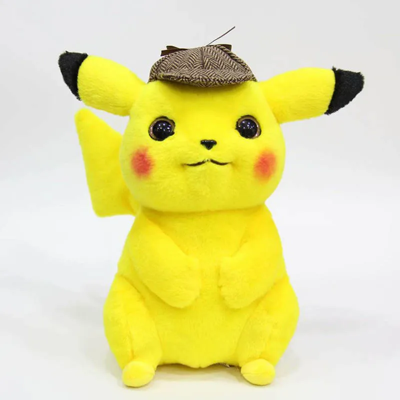

In [ ]:
image = Image.open(link).convert('RGB')
predict(image)